In [1]:
import muon as mu 
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xarray as xr
import scanpy as sc
import anndata as ad
from pathlib import Path
import cnmf
import mygene


/home/users/ymo/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# read the cNMF gene matrix (in txt), plot top x gene in the program 
def plot_top_gene_per_program(path, program_num = 0, num_gene = 10, species = "human"):

    # read cNMF gene program matrix
    df = pd.read_csv(path, sep='\t', index_col=0)
    df_sorted = df.iloc[program_num].nlargest(num_gene) #local the top x gene 

    # rename gene
    df_renamed = convert_with_mygene(df_sorted, species = species)

    # Create the plot
    fig, ax = plt.subplots(figsize=(5, 8))

    # Create horizontal bar plot
    bars = ax.barh(range(len(df_renamed)), df_renamed.values, color='#808080', alpha=0.8)

    # Customize the plot
    ax.set_yticks(range(len(df_renamed)))
    ax.set_yticklabels(df_renamed.index, fontsize=10)
    ax.set_xlabel('Program Specificity (z-score)', fontsize=11)

    # Format x-axis to match your reference
    ax.set_xlim(0, max(df_renamed.values) * 1.1)
    ax.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

    # Add grid
    ax.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # set title
    ax.set_title(f"Top {num_gene} in program {program_num}" , fontsize=14, fontweight='bold')

# replace EnsemblID by gene name given the dataframe with EnsemblID as the index
def convert_with_mygene(dataframe, species='human'):

    mg = mygene.MyGeneInfo()
    
    # Query multiple genes at once
    result = mg.querymany(dataframe.index, 
                         scopes='ensembl.gene', 
                         fields='symbol,name', 
                         species='human')
    
    # Create mapping dictionary
    mapping = {}
    for item in result:
        if 'symbol' in item and 'query' in item:
            mapping[item['query']] = item['symbol']

        elif 'query' in item:
            mapping[item['query']] = item['query']  # Keep original if no symbol

    new_dataframe = dataframe.rename(index=mapping)
    
    return new_dataframe

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


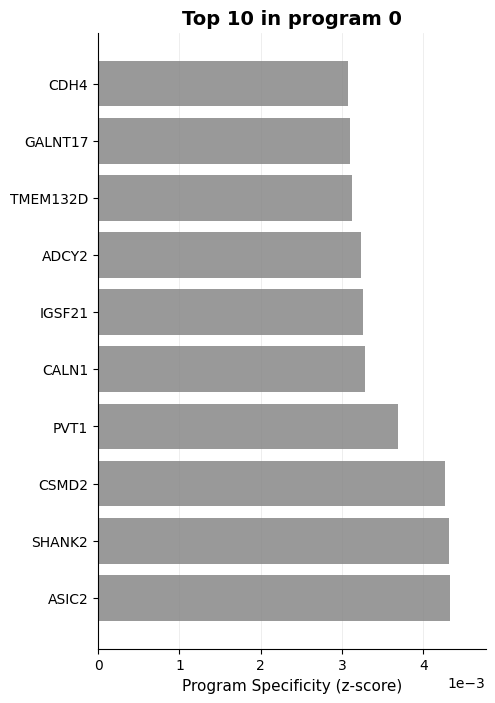

In [9]:
plot_top_gene_per_program('/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Script/Revant_code/original_code/analysis/240701_cNMF/output/all/consensus_NMF/consensus_NMF.spectra.k_100.dt_0_2.consensus.txt')


In [102]:
# plot top x GO terms with path to txt file 
def top_GO_per_program(path, numm_term = 10,  program_num = 0, p_value_name = "Adjusted P-value", title = "GO Term"):

    # read txt file
    df = pd.read_csv(path, sep='\t', index_col=0)

    # local to a program and isolate Term
    df_program = df.loc[df['program_name'] == program_num]

    # rename index
    df_program.index = df_program['Term']

    # sort by the smallest p value
    df_sort = df_program[p_value_name].nsmallest(numm_term)

    # -log10 tranform
    df_sort_log = -np.log10(df_sort)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create horizontal bar plot
    bars = ax.barh(range(len(df_sort_log)), df_sort_log.values, color='#808080', alpha=0.8)

    # Customize the plot
    ax.set_yticks(range(len(df_sort_log)))
    ax.set_yticklabels(df_sort_log.index, fontsize=10)
    ax.set_xlabel('Adjusted P-value(-10)', fontsize=11)

    # Format x-axis to match your reference
    ax.set_xlim(0, max(df_sort_log.values))
    ax.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

    # Add grid
    ax.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add title
    ax.set_title(title, fontsize=14, fontweight='bold')

    # Adjust layout
    plt.tight_layout()

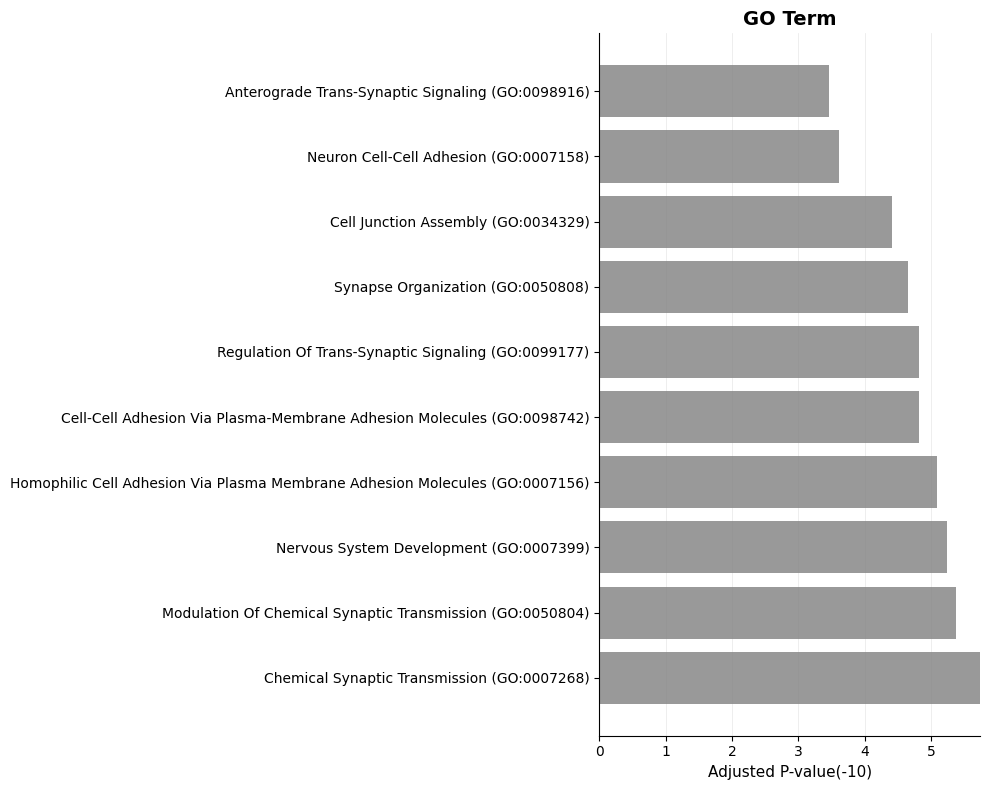

In [103]:
top_GO_per_program("/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Script/Revant_code/original_code/analysis/240807_cNMF_eval_pipeline_analysis/100/100_GO_term_enrichment.txt")


In [60]:

# Use scanpy's plotting function
import matplotlib.colors as mcolors

def plot_umap_per_program(mdata_path, usage_path, program_num = 0, color = 'purple'):

    # read cell and program data
    mdata = mu.read_h5mu(mdata_path)
    cell_usage = pd.read_csv(usage_path, sep='\t', index_col=0)


    adata_plot = mdata['rna'].copy()
    adata_plot.obs['cell_program_loading'] = cell_usage.iloc[:,program_num]

    
    colors = ['lightgrey', color]
    n_bins = 100
    cmap = mcolors.LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

    sc.pl.umap(adata_plot, color = 'cell_program_loading', cmap = cmap )


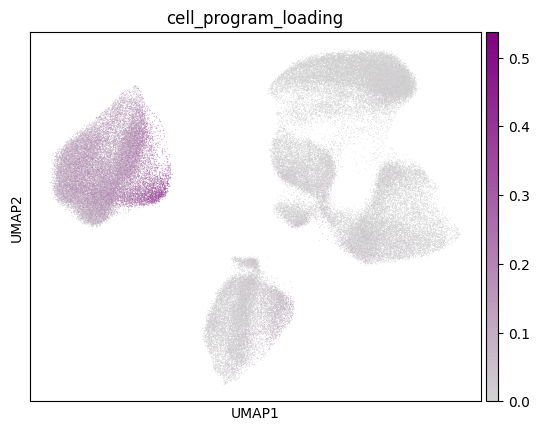

In [107]:
plot_umap_per_program("/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Script/Revant_code/original_code/analysis/240816_clustering_annotation_package/cNMF_100_0.2_preprocessed.h5mu",
"/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Script/Revant_code/original_code/analysis/240701_cNMF/output/all/consensus_NMF/consensus_NMF.usages.k_100.dt_0_2.consensus.txt")

In [ ]:
def plot_motif_per_program(path, numm_term = 10,  program_num = 0, title = "Motif", p_value_name = "Adjusted P-value"):

    # read txt file
    df = pd.read_csv(path, sep='\t', index_col=0)

    # local to a program and isolate Term
    df_program = df.loc[df['program_name'] == program_num]

    # rename index
    df_program.index = df_program['motif']

    # sort by the smallest p value
    df_sort = df_program[p_value_name].nsmallest(numm_term)

    # -log10 tranform
    df_sort_log = -np.log10(df_sort)

    # Create the plot
    fig, ax = plt.subplots(figsize=(5, 8))

    # Create horizontal bar plot
    bars = ax.barh(range(len(df_sort_log)), df_sort_log.values, color='#808080', alpha=0.8)

    # Customize the plot
    ax.set_yticks(range(len(df_sort_log)))
    ax.set_yticklabels(df_sort_log.index, fontsize=10)
    ax.set_xlabel('Adjusted P-value(-10)', fontsize=11)

    # Format x-axis to match your reference
    ax.set_xlim(0, max(df_sort_log.values))
    ax.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

    # Add grid
    ax.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


    # Add title
    ax.set_title(title, fontsize=14, fontweight='bold')


    # Adjust layout
    plt.tight_layout()

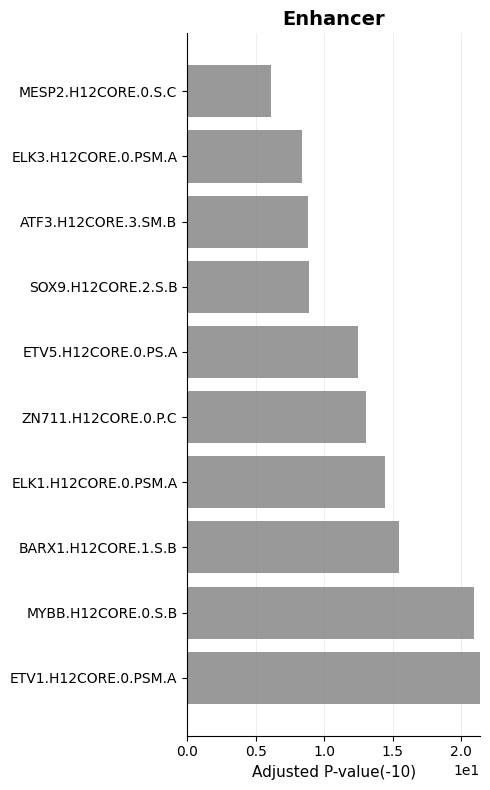

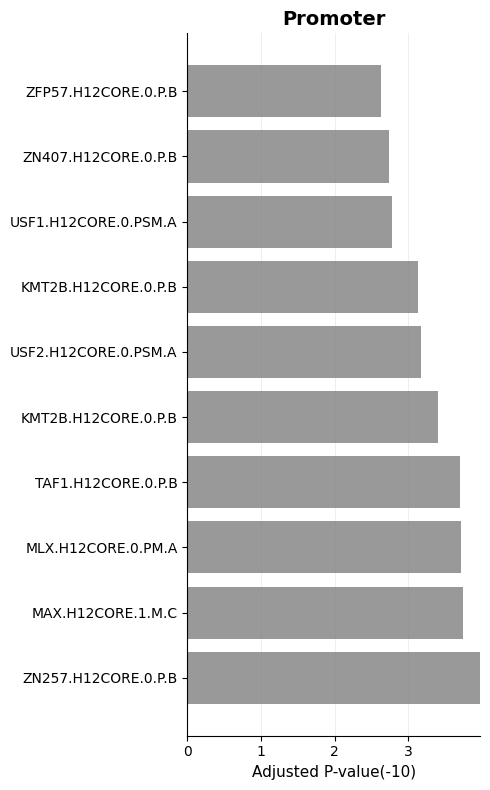

In [105]:
plot_motif_per_program("/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Script/Revant_code/original_code/analysis/241119_scE2G_motif_enrichment/cNMF_100_motif_enrichment_enhancer.txt", 
p_value_name ="adj_pval",
title = "Enhancer")

plot_motif_per_program("/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Script/Revant_code/original_code/analysis/241119_scE2G_motif_enrichment/cNMF_100_motif_enrichment_promoter.txt", 
p_value_name ="adj_pval",
title = "Promoter")

In [2]:
df = pd.read_csv("/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Script/Revant_code/original_code/shared/250110_ipsc_ec_dashboard_setup/cNMF_100/cNMF_100_gene_sample_D0_perturbation_association.txt",
                sep = "\t")

In [5]:
df_program = df.loc[df["program_name"] == 0]

/oak/stanford/groups/engreitz/Users/ymo/miniforge3/envs/NMF_Benchmarking/lib/python3.9/site-packages/bioinfokit/visuz.py:153: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['color_add_axy'].fillna(color[1], inplace=True)  # intermediate
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


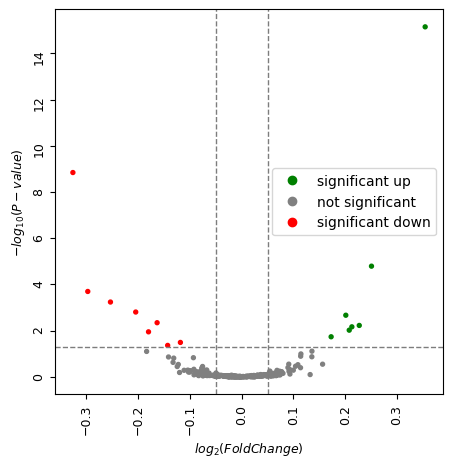

In [25]:
from bioinfokit import visuz
import pandas as pd

# Your data in DataFrame
visuz.GeneExpression.volcano(
    df=df_program, 
    lfc='log2FC',           # your log2FC column name
    pv='adj_pval',          # your p-value column name  
    genenames='target_name',       # your gene names column
    lfc_thr=(0.05, 0.05),     # fold change thresholds (down, up)
    pv_thr=(0.05, 0.05),            # p-value threshold
    geneid=df_program['target_name'],          # gene ID column for labeling
    gstyle=1,               # plot style
    show=True,              # show plot
    plotlegend=True,        # show legend
    figname='volcano',     # save as volcano.png
    sign_line=True,
    axtickfontname = "DejaVu Sans"
    )


Text(0.5, 1.0, 'volcano plot for program 0')

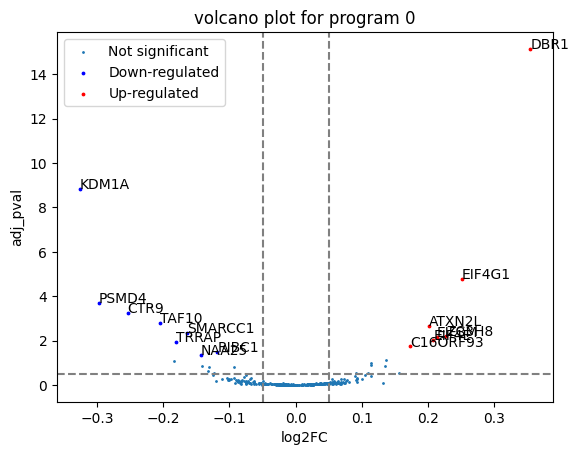

In [26]:

plt.scatter(x=df_program['log2FC'],y=df_program['adj_pval'].apply(lambda x:-np.log10(x)),s=1,label="Not significant")

# highlight down- or up- regulated genes
down = df_program[(df_program['log2FC']<=-0.05)&(df_program['adj_pval']<=0.05)]
up = df_program[(df_program['log2FC']>=0.05)&(df_program['adj_pval']<=0.05)]

plt.scatter(x=down['log2FC'],y=down['adj_pval'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
plt.scatter(x=up['log2FC'],y=up['adj_pval'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")

for i,r in up.iterrows():
    plt.text(x=r['log2FC'],y=-np.log10(r['adj_pval']),s=r['target_name'])

for i,r in down.iterrows():
    plt.text(x=r['log2FC'],y=-np.log10(r['adj_pval']),s=r['target_name'])
    
plt.xlabel("log2FC")
plt.ylabel("adj_pval")
plt.axvline(-0.05,color="grey",linestyle="--")
plt.axvline(0.05,color="grey",linestyle="--")
plt.axhline(0.5,color="grey",linestyle="--")
plt.legend()
plt.title("volcano plot for program 0")